<a href="https://colab.research.google.com/github/Zaicevvv/GoIT-DSandML-Private/blob/main/HW13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Частина 1

**Cтворити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping

Завантажимо датасет та нормалізуємо дані.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

4422102/4422102 [==============================] - 0s 0us/step


Функція відслідковування історії навчання.

In [3]:
def plot_history(hst):
  plt.figure(figsize=(13,4))

  plt.subplot(1, 2, 1)
  plt.plot(hst.history['loss'], label='train')
  plt.plot(hst.history['val_loss'], label='test')
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot([round(100*e,2) for e in hst.history['sparse_categorical_accuracy']], label='train')
  plt.plot([round(100*e,2) for e in hst.history['val_sparse_categorical_accuracy']], label='test')
  plt.title('Accuracy')
  plt.ylim(0, 100)
  plt.legend()
  plt.tight_layout()
  plt.show()

Побудуємо, навчимо та перевіримо модель

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 64)         

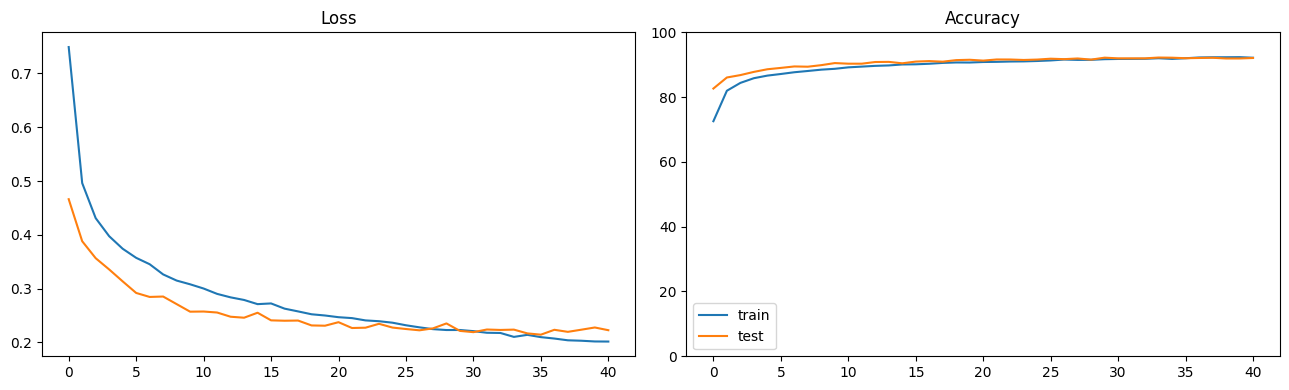

0.9136999845504761

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10)
  ])
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.001),
    metrics=[SparseCategoricalAccuracy()]
    )
model.summary()

history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(x_test, y_test)
plot_history(history)
test_acc

Висновок:  
В мережі з попереднього завдання без згорткових шарів вдалося досягти 87% точності.  
Ця ж модель розігналась до 91.3%.  
Ця модель краща =)

# Частина 2

**Використаємо VGG16 в якості згорткової основи.
Навчимо отриману мережу на даних із датасету fasion_mnist. Під час навчання використаємо прийоми донавчання та виділення ознак.**

In [4]:
from keras.applications.vgg16 import VGG16
from tensorflow.image import resize

Побудуємо, навчимо та перевіримо модель

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14781642 (56.39 MB)
Trainable params: 7146378 (27.26 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________
Epoch 1/50
1875/1875 [==============================] - 32s 16ms/step - loss: 0.4725 - sparse_categorical_accuracy: 0.8356 - val_loss: 0.362

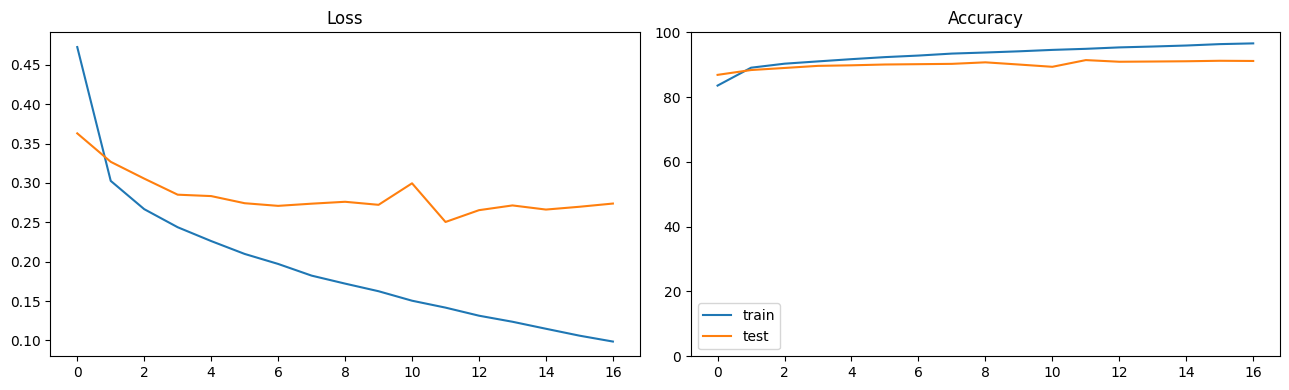

0.9143000245094299

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train = np.concatenate([x_train, x_train, x_train], axis=-1)
x_test = np.concatenate([x_test, x_test, x_test], axis=-1)

x_train = resize(x_train, (32, 32))
x_test = resize(x_test, (32, 32))

x_train = x_train / 255.0
x_test = x_test / 255.0

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential([
   conv_base,
   Flatten(),
   Dense(128, activation="relu"),
   Dense(10),
])
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-5),
    metrics=[SparseCategoricalAccuracy()]
    )
model.summary()

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(x_test, y_test)
plot_history(history)
test_acc

In [11]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.86      0.87      1000
           3       0.90      0.91      0.91      1000
           4       0.84      0.87      0.85      1000
           5       0.98      0.99      0.98      1000
           6       0.76      0.76      0.76      1000
           7       0.96      0.97      0.97      1000
           8       0.98      0.99      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**Висновок:**  
Вдалося досягти точності у 91.4%.  
Це вище ніж у попердніх моделей, тож використання VGG16 в якості згорткової основи і прийомів донавчання та виділення ознак покращило результат.